In [8]:
from google.colab import drive
import pandas as pd
import os
from io import StringIO
# Monter Google Drive
drive.mount('/content/drive', force_remount= True) #force_remount = True permet d'avoir un fichier mis à jour si modifs sur google drive
df=pd.read_csv('/content/drive/MyDrive/Datascientest/Projet_accidents/Dataset/2019_2023/df_machine_learning.csv')
df.gravité_accident.value_counts()

Mounted at /content/drive


,count
gravité_accident,
2,175525
3,82229
4,15472


In [9]:
mapping = {2: 'survivant',3: 'survivant', 4: 'mort'}
df['gravité_accident'] = df['gravité_accident'].map(mapping)
df.gravité_accident.value_counts()

,count
gravité_accident,
survivant,257754
mort,15472


Import des bibliothèques nécessaires

In [10]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score
import seaborn as sns
from sklearn.model_selection import GridSearchCV


Random Forest

Accuracy du modèle : 0.94
Précision : 0.91
Rappel : 0.94
F1-score : 0.92

Rapport de Classification :
              precision    recall  f1-score   support

        mort       0.28      0.06      0.10      3090
   survivant       0.95      0.99      0.97     51556

    accuracy                           0.94     54646
   macro avg       0.61      0.53      0.53     54646
weighted avg       0.91      0.94      0.92     54646



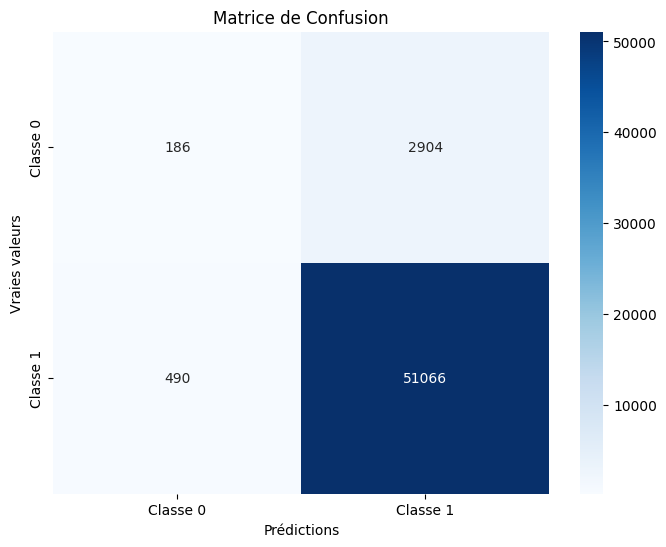

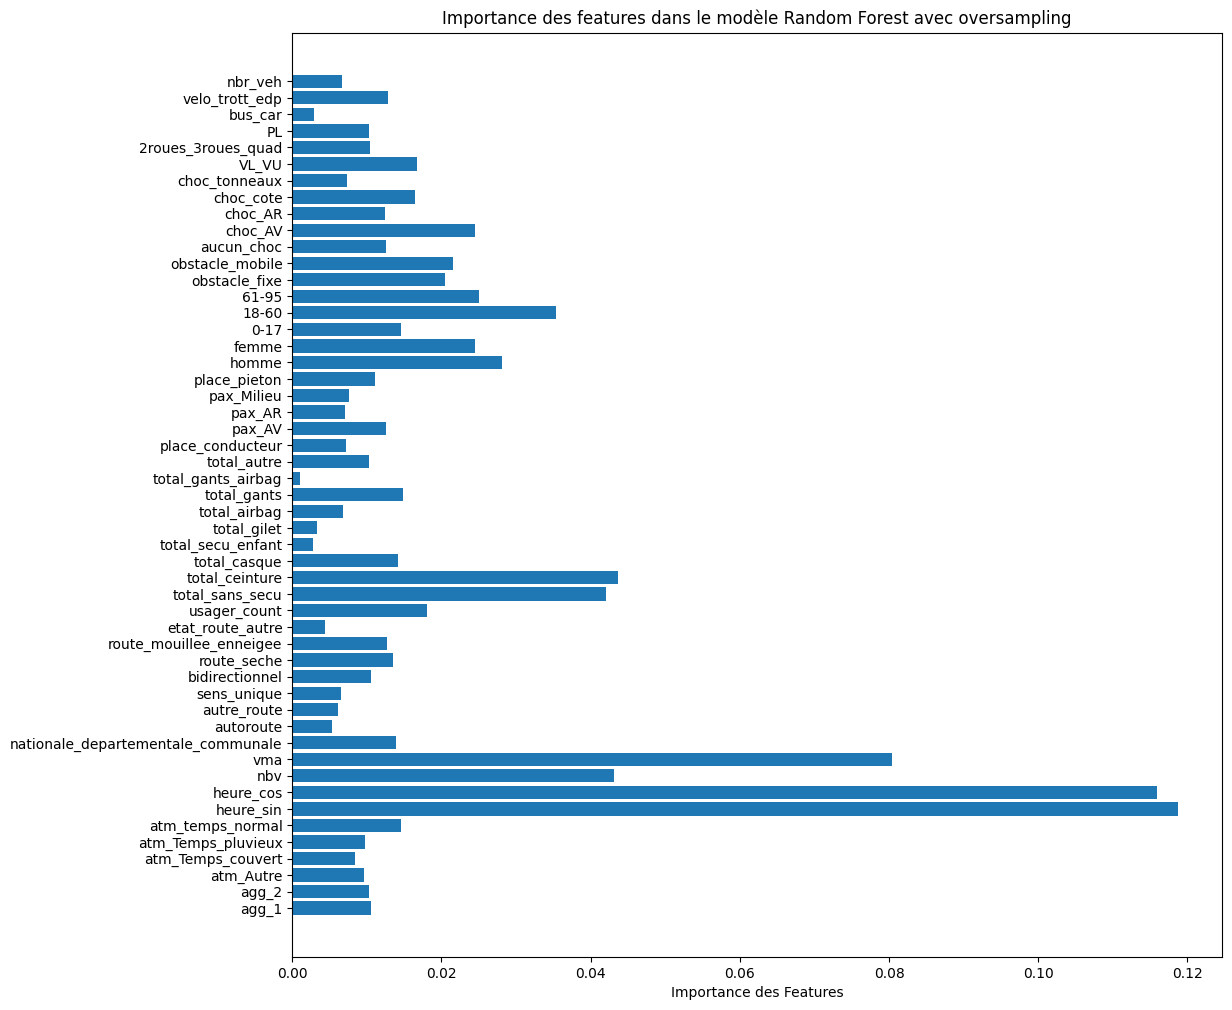

In [11]:
X = df.drop(['Num_Acc', 'lat', 'long', 'jour', 'mois', 'date', 'an', 'hrmn', 'dep', 'int', 'col', 'tué', 'blessé_léger','indemne', 'blessé_hospitalisé', 'gravité_accident'], axis=1)
y = df['gravité_accident']


# Définition de la classe pour la transformation de l'heure
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    """Transforme une colonne de type heure en variables cycliques sin et cos."""
    def __init__(self, period=24):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(float)  # Assurer que les valeurs sont numériques
        X_sin = np.sin(2 * np.pi * X / self.period)
        X_cos = np.cos(2 * np.pi * X / self.period)
        return np.c_[X_sin, X_cos]  # Retourne un array 2D avec sin et cos


# Séparer en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Liste des variables catégorielles et cycliques
categorical_features = ['agg', 'atm']  # Encodage
cyclical_features = ['heure']  # Transformation cyclique
passthrough_features = ['nbv', 'vma','nationale_departementale_communale', 'autoroute', 'autre_route',
       'sens_unique', 'bidirectionnel', 'route_seche',
       'route_mouillee_enneigee', 'etat_route_autre', 'usager_count',
        'total_sans_secu', 'total_ceinture', 'total_casque',
       'total_secu_enfant', 'total_gilet', 'total_airbag', 'total_gants',
       'total_gants_airbag', 'total_autre', 'place_conducteur', 'pax_AV',
       'pax_AR', 'pax_Milieu', 'place_pieton', 'homme', 'femme', '0-17',
       '18-60', '61-95', 'obstacle_fixe', 'obstacle_mobile', 'aucun_choc',
       'choc_AV', 'choc_AR', 'choc_cote', 'choc_tonneaux', 'VL_VU',
       '2roues_3roues_quad', 'PL', 'bus_car', 'velo_trott_edp', 'nbr_veh']  # À laisser inchangées

# Appliquer le ColumnTransformer avec `remainder='passthrough'`
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('cyclical', CyclicalFeatures(), cyclical_features)], remainder='passthrough')

# Définir la pipeline complète
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])

# Entraîner le modèle
pipeline.fit(X_train, y_train)

# Prédictions
y_pred = pipeline.predict(X_test)

# Évaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy du modèle : {accuracy:.2f}")

# Précision, Rappel, F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Rapport de classification
class_report = classification_report(y_test, y_pred)


# Afficher les résultats détaillés
print(f"Précision : {precision:.2f}")
print(f"Rappel : {recall:.2f}")
print(f"F1-score : {f1:.2f}")
print("\nRapport de Classification :")
print(class_report)

# Matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de Confusion')
plt.show()


# Récupérer l'importance des features
# Récupérer le modèle du classifieur après l'entraînement
model = pipeline.named_steps['classifier']

# Accéder aux importances des features
importances = model.feature_importances_

# Récupérer les noms des features après transformation
# Utiliser l'encodeur OneHotEncoder pour gérer les variables catégorielles encodées
# et la transformation cyclique pour obtenir les noms des features résultants.
cat_columns = pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_features)
cyclical_columns = ['heure_sin', 'heure_cos']  # Ces noms sont définis par la transformation de l'heure

# Les noms des features après transformation
features = np.concatenate([cat_columns, cyclical_columns, passthrough_features])

# Tracer l'importance des features
plt.figure(figsize=(12, 12))
plt.barh(features, importances)
plt.xlabel("Importance des Features")
plt.title("Importance des features dans le modèle Random Forest avec oversampling")
plt.show()

Random Forest avec les variables les plus importantes: vma, nbv, heure, total_sans_secu, nationale_communale_departementale

Accuracy du modèle : 0.94
Précision : 0.90
Rappel : 0.94
F1-score : 0.92

Rapport de Classification :
              precision    recall  f1-score   support

        mort       0.16      0.01      0.02      3090
   survivant       0.94      1.00      0.97     51556

    accuracy                           0.94     54646
   macro avg       0.55      0.50      0.49     54646
weighted avg       0.90      0.94      0.92     54646



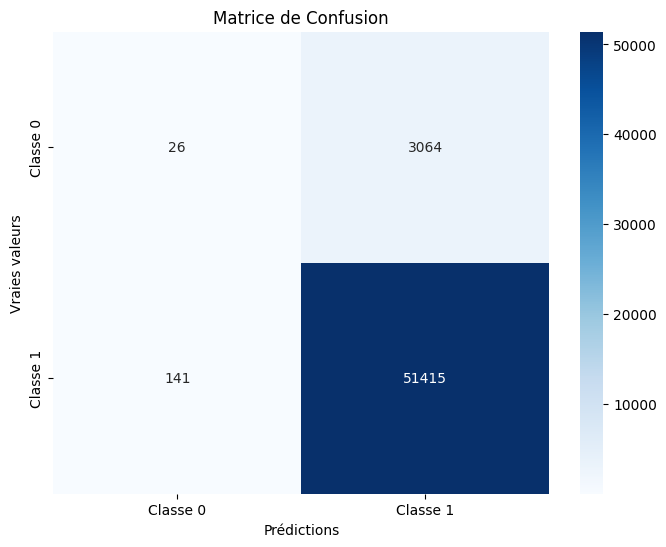

In [12]:
# Préparation des données
X = df.drop(['Num_Acc', 'total_ceinture', 'total_casque',
       'total_secu_enfant', 'total_gilet', 'total_airbag', 'total_gants',
       'total_gants_airbag', 'total_autre', 'place_conducteur', 'pax_AV',
       'pax_AR', 'pax_Milieu', 'place_pieton', 'homme', 'femme', '0-17',
       '18-60', '61-95', 'obstacle_fixe', 'obstacle_mobile', 'aucun_choc',
       'choc_AV', 'choc_AR', 'choc_cote', 'choc_tonneaux', 'VL_VU',
       '2roues_3roues_quad', 'PL', 'bus_car', 'velo_trott_edp', 'nbr_veh','autoroute', 'autre_route',
       'sens_unique', 'bidirectionnel', 'route_seche', 'atm',
       'route_mouillee_enneigee', 'etat_route_autre', 'usager_count','lat', 'long', 'jour', 'mois', 'date', 'an', 'hrmn', 'dep', 'int', 'col', 'tué', 'blessé_léger','indemne', 'blessé_hospitalisé', 'gravité_accident'], axis=1)
y = df['gravité_accident']

# Définition de la classe pour la transformation de l'heure
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    """Transforme une colonne de type heure en variables cycliques sin et cos."""
    def __init__(self, period=24):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(float)  # Assurer que les valeurs sont numériques
        X_sin = np.sin(2 * np.pi * X / self.period)
        X_cos = np.cos(2 * np.pi * X / self.period)
        return np.c_[X_sin, X_cos]  # Retourne un array 2D avec sin et cos


# Séparer en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Liste des variables catégorielles et cycliques
categorical_features = ['agg']  # Encodage
cyclical_features = ['heure']  # Transformation cyclique
passthrough_features = ['nbv', 'vma','nationale_departementale_communale',
       'total_sans_secu']  # À laisser inchangées

# Appliquer le ColumnTransformer avec `remainder='passthrough'`
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('cyclical', CyclicalFeatures(), cyclical_features)], remainder='passthrough')

# Définir la pipeline complète
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])

# Entraîner le modèle
pipeline.fit(X_train, y_train)

# Prédictions
y_pred = pipeline.predict(X_test)

# Évaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy du modèle : {accuracy:.2f}")

# Précision, Rappel, F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Rapport de classification
class_report = classification_report(y_test, y_pred)


# Afficher les résultats détaillés
print(f"Précision : {precision:.2f}")
print(f"Rappel : {recall:.2f}")
print(f"F1-score : {f1:.2f}")
print("\nRapport de Classification :")
print(class_report)

# Matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de Confusion')
plt.show()




Random Forest avec oversampling


Accuracy du modèle avec oversampling : 0.93
Accuracy du modèle : 0.93
Précision : 0.91
Rappel : 0.93
F1-score : 0.92

Rapport de Classification :
              precision    recall  f1-score   support

        mort       0.24      0.13      0.17      3090
   survivant       0.95      0.97      0.96     51556

    accuracy                           0.93     54646
   macro avg       0.60      0.55      0.57     54646
weighted avg       0.91      0.93      0.92     54646



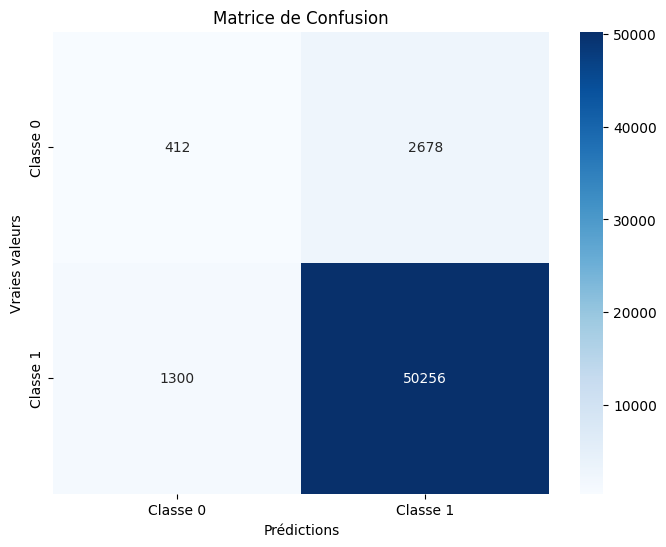

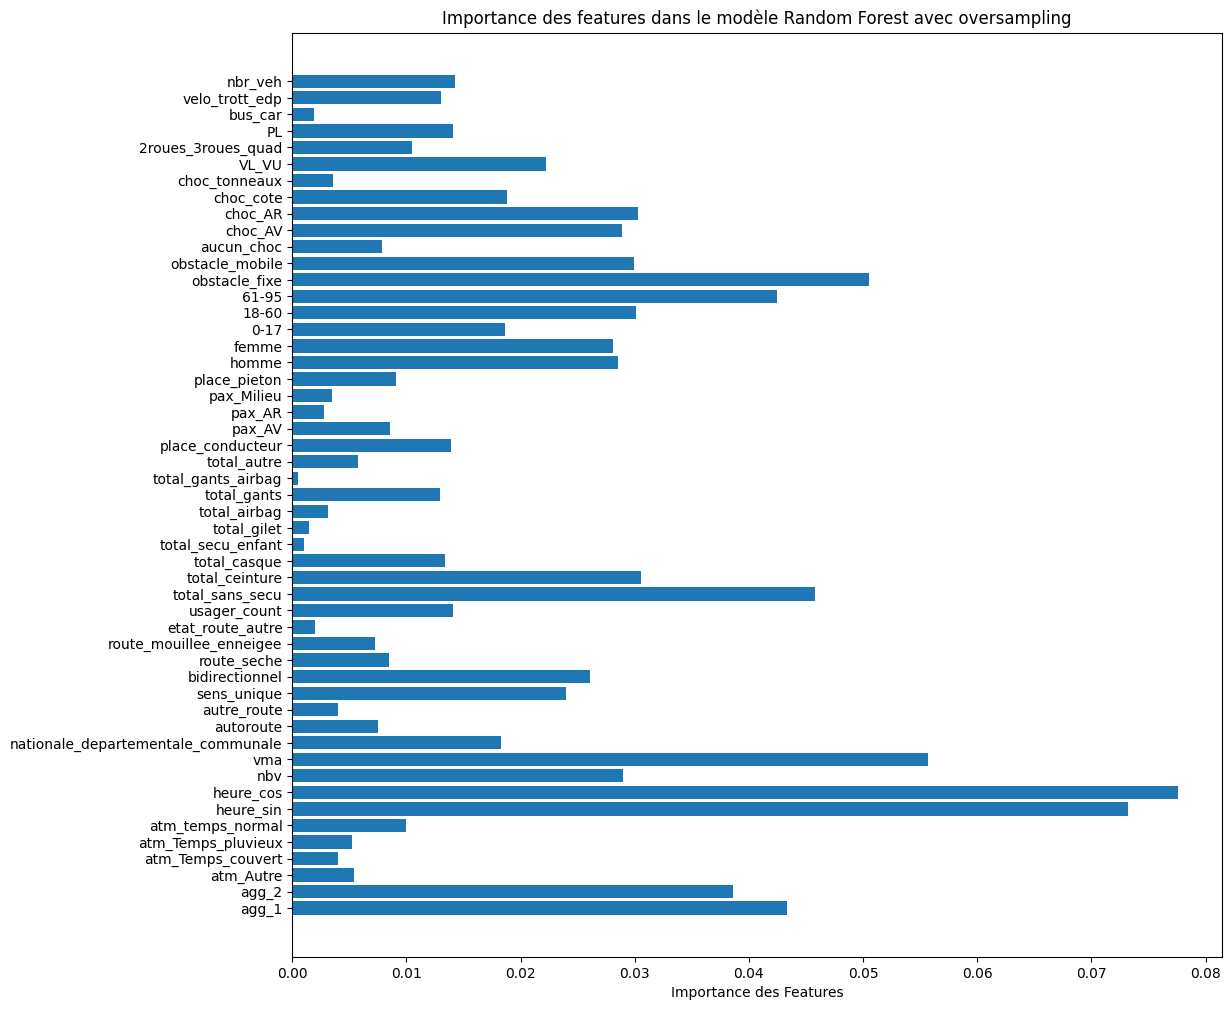

In [14]:
# Préparation des données
X = df.drop(['Num_Acc', 'lat', 'long', 'jour', 'mois', 'date', 'an', 'hrmn', 'dep', 'int', 'col', 'tué', 'blessé_léger','indemne', 'blessé_hospitalisé', 'gravité_accident'], axis=1)
y = df['gravité_accident']

# Définition de la classe pour la transformation de l'heure
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    """Transforme une colonne de type heure en variables cycliques sin et cos."""
    def __init__(self, period=24):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(float)  # Assurer que les valeurs sont numériques
        X_sin = np.sin(2 * np.pi * X / self.period)
        X_cos = np.cos(2 * np.pi * X / self.period)
        return np.c_[X_sin, X_cos]  # Retourne un array 2D avec sin et cos


# Séparer en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Liste des variables catégorielles et cycliques
categorical_features = ['agg', 'atm']  # Encodage
cyclical_features = ['heure']  # Transformation cyclique
passthrough_features = ['nbv', 'vma','nationale_departementale_communale', 'autoroute', 'autre_route',
       'sens_unique', 'bidirectionnel', 'route_seche',
       'route_mouillee_enneigee', 'etat_route_autre', 'usager_count',
       'total_sans_secu', 'total_ceinture', 'total_casque',
       'total_secu_enfant', 'total_gilet', 'total_airbag', 'total_gants',
       'total_gants_airbag', 'total_autre', 'place_conducteur', 'pax_AV',
       'pax_AR', 'pax_Milieu', 'place_pieton', 'homme', 'femme', '0-17',
       '18-60', '61-95', 'obstacle_fixe', 'obstacle_mobile', 'aucun_choc',
       'choc_AV', 'choc_AR', 'choc_cote', 'choc_tonneaux', 'VL_VU',
       '2roues_3roues_quad', 'PL', 'bus_car', 'velo_trott_edp', 'nbr_veh']  # À laisser inchangées

# Appliquer le ColumnTransformer avec `remainder='passthrough'`
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('cyclical', CyclicalFeatures(), cyclical_features)], remainder='passthrough')

# Appliquer SMOTE dans la pipeline (avant l'entraînement du modèle)
smote = SMOTE(random_state=42, sampling_strategy = 'auto', k_neighbors = 5)

# Définir la pipeline complète avec SMOTE
pipeline = imPipeline([
    ('preprocessor', preprocessor),  # Transformation des variables
    ('smote', smote),  # Oversampling via SMOTE
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))  # Classificateur
])

# Entraîner le modèle avec oversampling
pipeline.fit(X_train, y_train)

# Prédictions
y_pred = pipeline.predict(X_test)

# Évaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy du modèle avec oversampling : {accuracy:.2f}")

# Évaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy du modèle : {accuracy:.2f}")



# Précision, Rappel, F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Rapport de classification
class_report = classification_report(y_test, y_pred)


# Afficher les résultats détaillés
print(f"Précision : {precision:.2f}")
print(f"Rappel : {recall:.2f}")
print(f"F1-score : {f1:.2f}")
print("\nRapport de Classification :")
print(class_report)

# Matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de Confusion')
plt.show()

# Récupérer l'importance des features
# Récupérer le modèle du classifieur après l'entraînement
model = pipeline.named_steps['classifier']

# Accéder aux importances des features
importances = model.feature_importances_

# Récupérer les noms des features après transformation
# Utiliser l'encodeur OneHotEncoder pour gérer les variables catégorielles encodées
# et la transformation cyclique pour obtenir les noms des features résultants.
cat_columns = pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_features)
cyclical_columns = ['heure_sin', 'heure_cos']  # Ces noms sont définis par la transformation de l'heure

# Les noms des features après transformation
features = np.concatenate([cat_columns, cyclical_columns, passthrough_features])

# Tracer l'importance des features
plt.figure(figsize=(12, 12))
plt.barh(features, importances)
plt.xlabel("Importance des Features")
plt.title("Importance des features dans le modèle Random Forest avec oversampling")
plt.show()

Random Forest avec Undersampling

Accuracy du modèle avec undersampling : 0.72
Précision : 0.93
Rappel : 0.72
F1-score : 0.79

Rapport de Classification :
              precision    recall  f1-score   support

        mort       0.14      0.75      0.23      3090
   survivant       0.98      0.72      0.83     51556

    accuracy                           0.72     54646
   macro avg       0.56      0.73      0.53     54646
weighted avg       0.93      0.72      0.79     54646



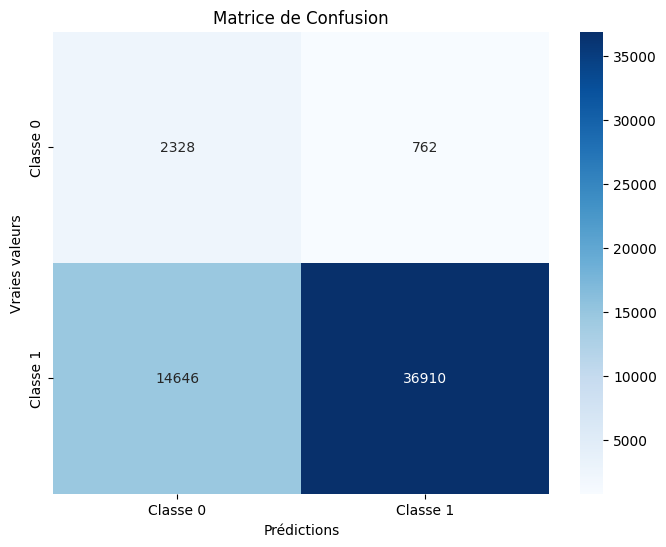

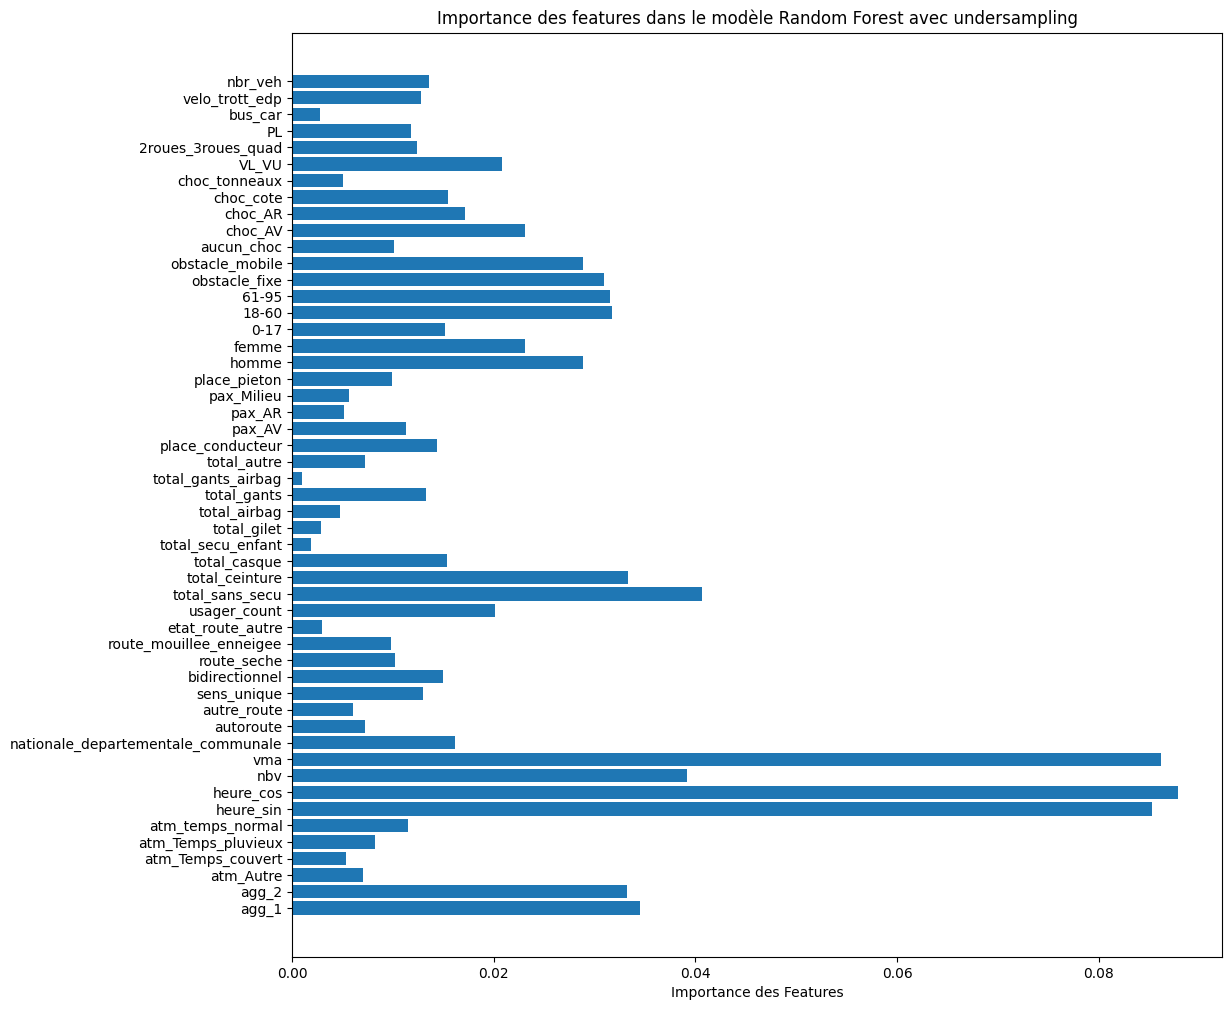

In [15]:

# Préparation des données
X = df.drop(['Num_Acc', 'lat', 'long', 'jour', 'mois', 'date', 'an', 'hrmn', 'dep', 'int', 'col', 'tué', 'blessé_léger','indemne', 'blessé_hospitalisé', 'gravité_accident'], axis=1)
y = df['gravité_accident']

# Définition de la classe pour la transformation de l'heure
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    """Transforme une colonne de type heure en variables cycliques sin et cos."""
    def __init__(self, period=24):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(float)  # Assurer que les valeurs sont numériques
        X_sin = np.sin(2 * np.pi * X / self.period)
        X_cos = np.cos(2 * np.pi * X / self.period)
        return np.c_[X_sin, X_cos]  # Retourne un array 2D avec sin et cos


# Séparer en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Liste des variables catégorielles et cycliques
categorical_features = ['agg', 'atm']  # Encodage
cyclical_features = ['heure']  # Transformation cyclique
passthrough_features = ['nbv', 'vma','nationale_departementale_communale', 'autoroute', 'autre_route',
       'sens_unique', 'bidirectionnel', 'route_seche',
       'route_mouillee_enneigee', 'etat_route_autre', 'usager_count',
       'total_sans_secu', 'total_ceinture', 'total_casque',
       'total_secu_enfant', 'total_gilet', 'total_airbag', 'total_gants',
       'total_gants_airbag', 'total_autre', 'place_conducteur', 'pax_AV',
       'pax_AR', 'pax_Milieu', 'place_pieton', 'homme', 'femme', '0-17',
       '18-60', '61-95', 'obstacle_fixe', 'obstacle_mobile', 'aucun_choc',
       'choc_AV', 'choc_AR', 'choc_cote', 'choc_tonneaux', 'VL_VU',
       '2roues_3roues_quad', 'PL', 'bus_car', 'velo_trott_edp', 'nbr_veh']  # À laisser inchangées


# Appliquer le ColumnTransformer avec `remainder='passthrough'`
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('cyclical', CyclicalFeatures(), cyclical_features)], remainder='passthrough')

# Appliquer RandomUnderSampler dans la pipeline (avant l'entraînement du modèle)
under_sampler = RandomUnderSampler(random_state=42)

# Définir la pipeline complète avec undersampling
pipeline = imPipeline([
    ('preprocessor', preprocessor),  # Transformation des variables
    ('under_sampler', under_sampler),  # Undersampling via RandomUnderSampler
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))  # Classificateur
])

# Entraîner le modèle avec undersampling
pipeline.fit(X_train, y_train)

# Prédictions
y_pred = pipeline.predict(X_test)

# Évaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy du modèle avec undersampling : {accuracy:.2f}")

# Précision, Rappel, F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Rapport de classification
class_report = classification_report(y_test, y_pred)

# Afficher les résultats détaillés
print(f"Précision : {precision:.2f}")
print(f"Rappel : {recall:.2f}")
print(f"F1-score : {f1:.2f}")
print("\nRapport de Classification :")
print(class_report)

# Matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de Confusion')
plt.show()

# Récupérer l'importance des features
# Récupérer le modèle du classifieur après l'entraînement
model = pipeline.named_steps['classifier']

# Accéder aux importances des features
importances = model.feature_importances_

# Récupérer les noms des features après transformation
# Utiliser l'encodeur OneHotEncoder pour gérer les variables catégorielles encodées
# et la transformation cyclique pour obtenir les noms des features résultants.
cat_columns = pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_features)
cyclical_columns = ['heure_sin', 'heure_cos']  # Ces noms sont définis par la transformation de l'heure

# Les noms des features après transformation
features = np.concatenate([cat_columns, cyclical_columns, passthrough_features])

# Tracer l'importance des features
plt.figure(figsize=(12, 12))
plt.barh(features, importances)
plt.xlabel("Importance des Features")
plt.title("Importance des features dans le modèle Random Forest avec undersampling")
plt.show()

Grrid search pour optimiser paramètres du modele avec toutes les variables. Utilisation de class_weight='balanced' pour gérer le déséquilibre des classes

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Meilleurs paramètres: {'classifier__class_weight': None, 'classifier__max_depth': None, 'classifier__n_estimators': 100}

📊 **Performance du modèle optimal**
Accuracy: 0.94
Precision: 0.91
Recall: 0.94
F1-score: 0.92

Rapport de Classification:
              precision    recall  f1-score   support

        mort       0.32      0.06      0.09      3090
   survivant       0.95      0.99      0.97     51556

    accuracy                           0.94     54646
   macro avg       0.63      0.52      0.53     54646
weighted avg       0.91      0.94      0.92     54646



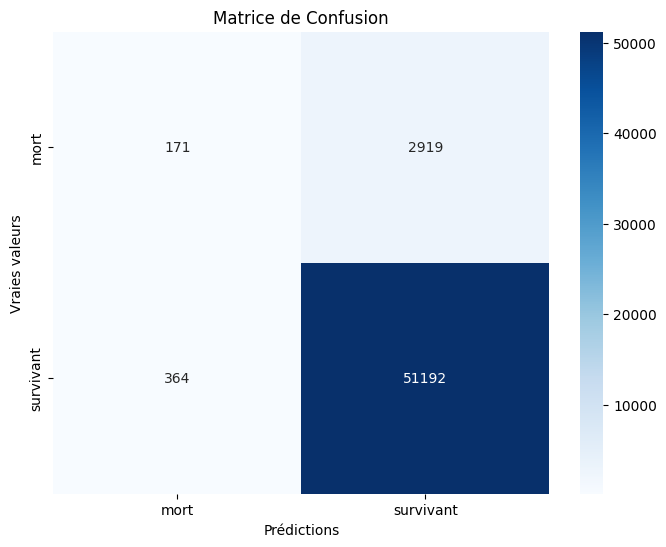

In [16]:
X = df.drop(['lat', 'long', 'jour', 'mois', 'date', 'an', 'hrmn', 'dep', 'int', 'col', 'tué', 'blessé_léger','indemne', 'blessé_hospitalisé', 'gravité_accident'], axis=1)
y = df['gravité_accident']


# Définition de la classe pour la transformation de l'heure
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    """Transforme une colonne de type heure en variables cycliques sin et cos."""
    def __init__(self, period=24):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(float)  # Assurer que les valeurs sont numériques
        X_sin = np.sin(2 * np.pi * X / self.period)
        X_cos = np.cos(2 * np.pi * X / self.period)
        return np.c_[X_sin, X_cos]  # Retourne un array 2D avec sin et cos


# Séparer en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Liste des variables catégorielles et cycliques
categorical_features = ['agg', 'atm']  # Encodage
cyclical_features = ['heure']  # Transformation cyclique
passthrough_features = ['nbv', 'vma','nationale_departementale_communale', 'autoroute', 'autre_route',
       'sens_unique', 'bidirectionnel', 'route_seche',
       'route_mouillee_enneigee', 'etat_route_autre', 'usager_count',
        'total_sans_secu', 'total_ceinture', 'total_casque',
       'total_secu_enfant', 'total_gilet', 'total_airbag', 'total_gants',
       'total_gants_airbag', 'total_autre', 'place_conducteur', 'pax_AV',
       'pax_AR', 'pax_Milieu', 'place_pieton', 'homme', 'femme', '0-17',
       '18-60', '61-95', 'obstacle_fixe', 'obstacle_mobile', 'aucun_choc',
       'choc_AV', 'choc_AR', 'choc_cote', 'choc_tonneaux', 'VL_VU',
       '2roues_3roues_quad', 'PL', 'bus_car', 'velo_trott_edp', 'nbr_veh']  # À laisser inchangées


# 📌 **Pipeline de preprocessing**
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('cyclical', CyclicalFeatures(), cyclical_features)
], remainder='passthrough')


# 📌 **Modèle de classification**
classifier = RandomForestClassifier(random_state=42,class_weight='balanced')

# 📌 **Pipeline principal avec imblearn Pipeline**
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Étape de transformation
    ('classifier', classifier)  # Modèle final
])

# 📌 **Définition de la grille de recherche**
param_grid = {

    'classifier__n_estimators': [50, 100, 200],  # Nombre d'arbres
    'classifier__max_depth': [10, 20, None],  # Profondeur maximale
    'classifier__class_weight': ['balanced', None]  # Tester 'balanced' et None
}

# 📌 **Lancer la GridSearchCV**
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1_weighted', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# 📌 **Afficher les meilleurs paramètres**
print("Meilleurs paramètres:", grid_search.best_params_)

# 📌 **Évaluation du modèle optimal**
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)



accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\n📊 **Performance du modèle optimal**")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")
print("\nRapport de Classification:")
print(classification_report(y_test, y_pred))

# 📌 **Matrice de confusion**
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de Confusion")
plt.show()



GridSearch avec les variables les plus importantes pour optimiser les paramètres du modèle

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Meilleurs paramètres: {'classifier__max_depth': 10, 'classifier__n_estimators': 50}

📊 **Performance du modèle optimal**
Accuracy: 0.70
Precision: 0.67
Recall: 0.70
F1-score: 0.66

Rapport de Classification:
              precision    recall  f1-score   support

           2       0.73      0.91      0.81     35156
           3       0.57      0.38      0.46     16400
           4       0.45      0.00      0.01      3090

    accuracy                           0.70     54646
   macro avg       0.58      0.43      0.42     54646
weighted avg       0.67      0.70      0.66     54646



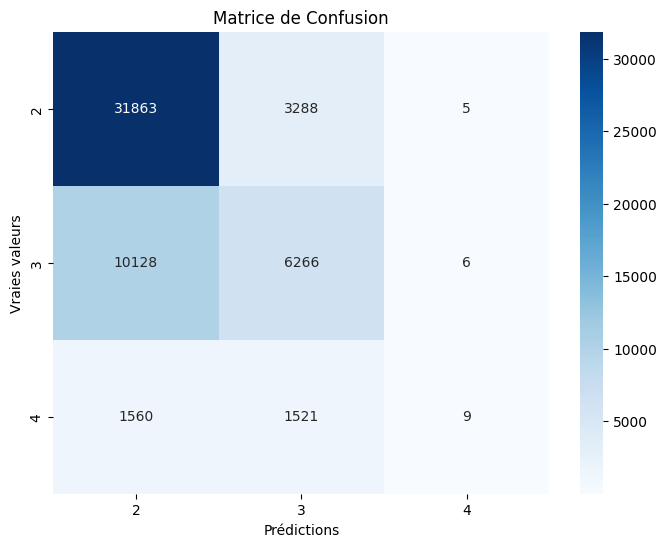

In [ ]:

# Préparation des données
X = df.drop(['Num_Acc', 'total_ceinture', 'total_casque',
       'total_secu_enfant', 'total_gilet', 'total_airbag', 'total_gants',
       'total_gants_airbag', 'total_autre', 'place_conducteur', 'pax_AV',
       'pax_AR', 'pax_Milieu', 'place_pieton', 'homme', 'femme', '0-17',
       '18-60', '61-95', 'obstacle_fixe', 'obstacle_mobile', 'aucun_choc',
       'choc_AV', 'choc_AR', 'choc_cote', 'choc_tonneaux', 'VL_VU',
       '2roues_3roues_quad', 'PL', 'bus_car', 'velo_trott_edp', 'nbr_veh','autoroute', 'autre_route',
       'sens_unique', 'bidirectionnel', 'route_seche', 'atm',
       'route_mouillee_enneigee', 'etat_route_autre', 'usager_count','lat', 'long', 'jour', 'mois', 'date', 'an', 'hrmn', 'dep', 'int', 'col', 'tué', 'blessé_léger','indemne', 'blessé_hospitalisé', 'gravité_accident'], axis=1)
y = df['gravité_accident']

# Définition de la classe pour la transformation de l'heure
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    """Transforme une colonne de type heure en variables cycliques sin et cos."""
    def __init__(self, period=24):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(float)  # Assurer que les valeurs sont numériques
        X_sin = np.sin(2 * np.pi * X / self.period)
        X_cos = np.cos(2 * np.pi * X / self.period)
        return np.c_[X_sin, X_cos]  # Retourne un array 2D avec sin et cos


# Séparer en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 📌 **Définition des variables**
categorical_features = ['agg']
cyclical_features = ['heure']
passthrough_features = ['nbv', 'vma']

# 📌 **Pipeline de preprocessing**
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('cyclical', CyclicalFeatures(), cyclical_features)
], remainder='passthrough')

# 📌 **Modèle de classification**
classifier = RandomForestClassifier(random_state=42)

# 📌 **Pipeline principal avec imblearn Pipeline**
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Étape de transformation
    ('classifier', classifier)  # Modèle final
])

# 📌 **Définition de la grille de recherche**
param_grid = {

    'classifier__n_estimators': [50, 100, 200],  # Nombre d'arbres
    'classifier__max_depth': [10, 20, None],  # Profondeur maximale
}

# 📌 **Lancer la GridSearchCV**
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1_weighted', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# 📌 **Afficher les meilleurs paramètres**
print("Meilleurs paramètres:", grid_search.best_params_)

# 📌 **Évaluation du modèle optimal**
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)



accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\n📊 **Performance du modèle optimal**")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")
print("\nRapport de Classification:")
print(classification_report(y_test, y_pred))

# 📌 **Matrice de confusion**
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de Confusion")
plt.show()